В этом ноутбуке вам предстоит познакомиться с некоторыми техниками дообучения нейросетей

### Импорты, настройки, конфиг
Установим необходимые библиотеки

In [ ]:
%%capture
!pip3 install --upgrade pip numpy pytorch-lightning albumentations==0.4.6

In [ ]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, random_split
import torchvision
from torchvision import datasets, transforms, models

import albumentations as A
from albumentations.pytorch import ToTensorV2

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.callbacks import Callback, ModelCheckpoint

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Зададим гиперпараметры

In [ ]:
MEAN = (0.4914, 0.4822, 0.4465)
STD = (0.2023, 0.1994, 0.2010)

TRAIN_SUBPART = 0.3
VAL_SPLIT = 0.2

BATCH_SIZE = 32
MAX_EPOCHS = 10
BASE_LR = 5e-2

### Данные

В качестве датасета возьмем CIFAR10

In [ ]:
DEFAULT_TRANSFORM = A.Compose([A.Normalize(mean=MEAN, std=STD),
                               ToTensorV2()])

Напишем класс на pytorch для предобработки данных

In [ ]:
class CIFAR10(Dataset):
    def __init__(self, train, dataset_path='/cifar10', transformations=DEFAULT_TRANSFORM, should_download=True):
        self.dataset_train = torchvision.datasets.CIFAR10(dataset_path, train=train, download=should_download)
        self.transformations = transformations

    def __getitem__(self, index):
        (img, label) = self.dataset_train[index]
        img = np.asarray(img)
        if self.transformations is not None:
            return self.transformations(image=img)['image'], label
        return img, label

    def __len__(self):
        return len(self.dataset_train)

Обернем все необходимое для загрузки данных в lightning data module

In [ ]:
class CIFARDataModule(pl.LightningDataModule):

  def __init__(self, batch_size=BATCH_SIZE, train_transform=DEFAULT_TRANSFORM, val_transform=DEFAULT_TRANSFORM):
    super().__init__()

    self.batch_size = batch_size

    self.train_set = CIFAR10(True, transformations=train_transform)
    self.test_set = CIFAR10(False, transformations=val_transform)

    indices = list(range(len(self.train_set)))
    np.random.shuffle(indices)
    indices = indices[:int(round(len(indices) * TRAIN_SUBPART))]
    split = int(round(VAL_SPLIT * len(indices)))

    self.train_sampler = SubsetRandomSampler(indices[split:])
    self.val_sampler = SubsetRandomSampler(indices[:split])

  def setup(self, stage):
    print(f'Train: {len(self.train_sampler)} images\nValidation: {len(self.val_sampler)} images\nTest: {len(self.test_set)} images')

  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.train_set, sampler=self.train_sampler, batch_size=self.batch_size)

  def val_dataloader(self):
    return torch.utils.data.DataLoader(self.train_set, sampler=self.val_sampler, batch_size=self.batch_size)

  def test_dataloader(self):
    return torch.utils.data.DataLoader(self.test_set, batch_size=self.batch_size)

In [ ]:
%%capture
vis_data_module = CIFARDataModule(train_transform=ToTensorV2())

In [ ]:
%matplotlib inline

class_dict = {
  0: 'plane',
  1: 'car',
  2: 'bird',
  3: 'cat',
  4: 'deer',
  5: 'dog',
  6: 'frog',
  7: 'horse',
  8: 'ship',
  9: 'truck',
}

images, labels = next(iter(vis_data_module.train_dataloader()))

fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]).moveaxis(0, 2))
  label = int(labels[idx.item()])
  ax.set_title('Class ' + str(label) + f' ({class_dict[label]})')
  fig.tight_layout()

### Модель

В качестве базовой модели возьмем ResNet-18

In [ ]:
class ResNetClassifier(pl.LightningModule):
    def __init__(self, num_classes, transfer=True, freeze='most'):
        super().__init__()        

        self.resnet_model =  models.resnet18(pretrained=transfer)
        
        linear_size = list(self.resnet_model.children())[-1].in_features
        self.resnet_model.fc = nn.Linear(linear_size, num_classes)

        for child in list(self.resnet_model.children()):
                for param in child.parameters():
                    param.requires_grad = True

        if freeze == 'last':
            for child in list(self.resnet_model.children())[:-1]:
                for param in child.parameters():
                    param.requires_grad = False
        elif freeze == 'most':
            for child in list(self.resnet_model.children())[:-4]:
                for param in child.parameters():
                    param.requires_grad = False
        elif freeze != 'full':
            raise NotImplementedError('Wrong freezing parameter')
        
    def forward(self, x):
        return F.log_softmax(self.resnet_model(x), dim=1)

### Lightning-модуль

Напишем lightning-модуль для обучения/тестирования

In [ ]:
class LightningCIFARClassifier(pl.LightningModule):

  def __init__(self, lr_rate=BASE_LR, freeze='most'):
    super(LightningCIFARClassifier, self).__init__()
    
    self.model = ResNetClassifier(10, True, freeze)

    self.lr_rate = lr_rate

  def forward(self, x):
      return self.model(x)

  def cross_entropy_loss(self, logits, labels):
    return F.nll_loss(logits, labels)

  def training_step(self, train_batch, batch_idx):
      x, y = train_batch
      logits = self.forward(x)
      loss = self.cross_entropy_loss(logits, y)

      logs = {'train_loss': loss}

      acc = torch.sum(logits.argmax(dim=1) == y) / y.shape[0]
      self.log('train_acc', acc, on_step=True, prog_bar=True)
      self.log('train_loss', loss, on_step=True, prog_bar=True)

      return {'loss': loss, 'log': logs}

  def validation_step(self, val_batch, batch_idx):
      x, y = val_batch
      logits = self.forward(x)
      loss = self.cross_entropy_loss(logits, y)
      acc = torch.sum(logits.argmax(dim=1) == y) / y.shape[0]

      self.log('val_loss', loss, on_step=True, on_epoch=False)
      self.log('val_acc', acc, on_step=True, on_epoch=False)

      return {'val_loss': loss, 'val_acc': acc}

  def test_step(self, val_batch, batch_idx):
      x, y = val_batch
      logits = self.forward(x)
      loss = self.cross_entropy_loss(logits, y)
      acc = torch.sum(logits.argmax(dim=1) == y) / y.shape[0]

      self.log('test_loss', loss, on_step=True, on_epoch=False)
      self.log('test_acc', acc, on_step=True, on_epoch=False)

      return {'test_loss': loss, 'test_acc': acc}

  def validation_epoch_end(self, outputs):
      avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
      avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
      tensorboard_logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
      print('Accuracy: ', round(float(avg_acc), 3))
      self.log('val_acc', avg_acc, on_epoch=True, on_step=False)
      return {'val_loss': avg_loss, 'val_acc': avg_acc, 'log': tensorboard_logs}

  def test_epoch_end(self, outputs):
      avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
      avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
      tensorboard_logs = {'test_loss': avg_loss, 'test_acc': avg_acc}
      self.log('test_acc', avg_acc, on_epoch=True, on_step=False)
      return {'test_loss': avg_loss, 'test_acc': avg_acc, 'log': tensorboard_logs}

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr_rate)
    return [optimizer]

### Базовое обучение

In [ ]:
data_module = CIFARDataModule()

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath='runs/basic',
                                      filename='{epoch}-{val_acc:.3f}',
                                      monitor='val_acc', mode='max', save_top_k=1)
model = LightningCIFARClassifier()
trainer = pl.Trainer(gpus=1,
                     precision=16,
                     callbacks=[checkpoint_callback],
                     max_epochs=MAX_EPOCHS)
trainer.fit(model, data_module)

model_test = LightningCIFARClassifier.load_from_checkpoint(checkpoint_callback.best_model_path)
test_accuracy = trainer.test(model_test, data_module)[0]['test_acc']
print('Test accuracy: ', round(test_accuracy, 3))

## Разморозка весов

Обучение нейросетей требует большого объема данных и много времени. Часто удобно использовать веса, заранее полученные при обучении на некотором большом датасете (ImageNet, OpenImages). В зависимости от размера нашего набора данных, можно тренировать разное количество слоев (начиная с выхода нейросети), а остальные "заморозить".
Использовать можно следующую схему:

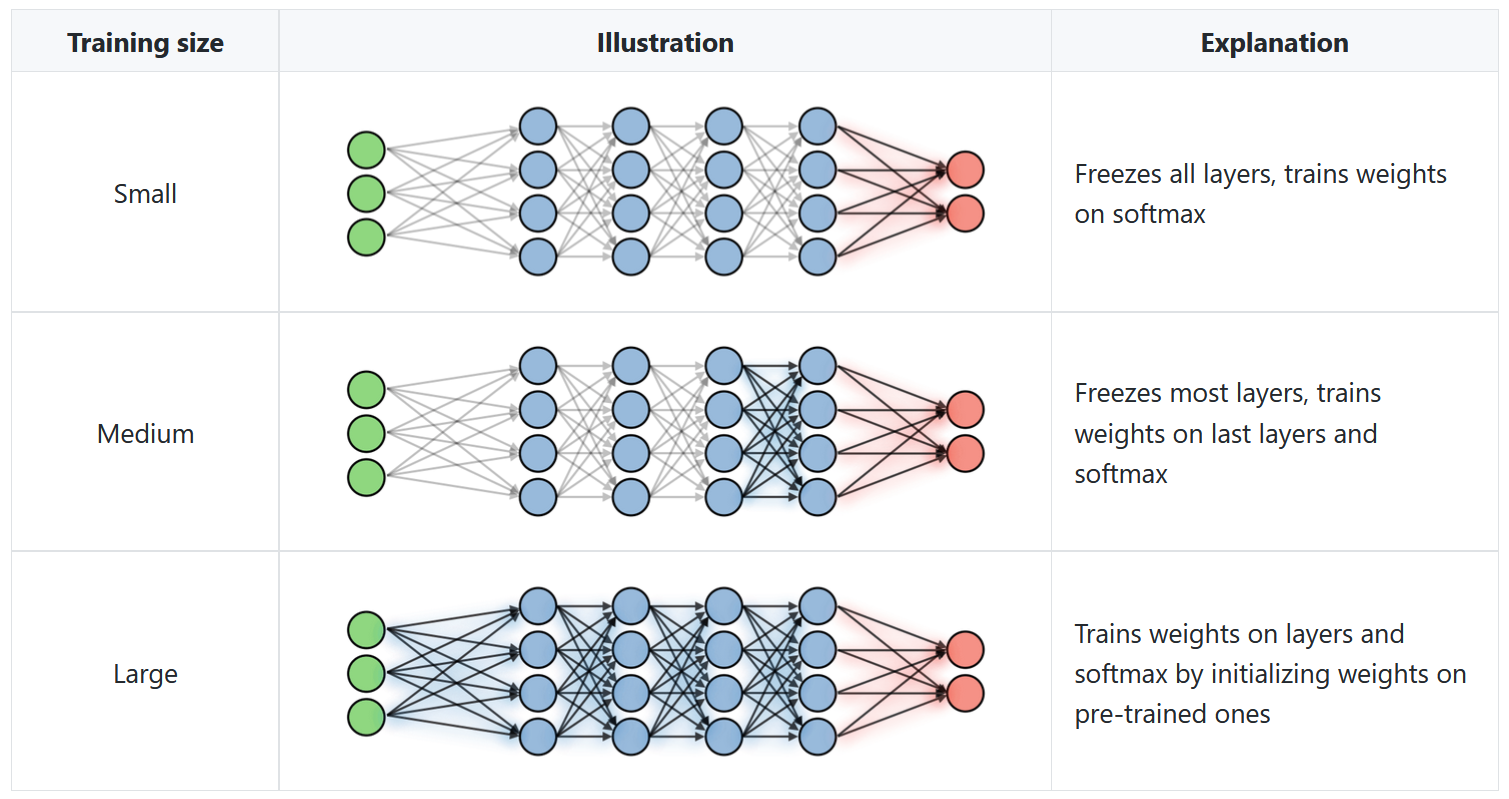

Попробуем обучить 3 нейросети с разным числом "размороженных" слоев: только последний слой (last), часть слоев (most), все слои (full)

In [ ]:
for unfreeze in ['last', 'most', 'full']:  
    checkpoint_callback = ModelCheckpoint(dirpath=f'runs/unfreeze_{unfreeze}',
                                          filename='{epoch}-{val_acc:.3f}',
                                          monitor='val_acc', mode='max', save_top_k=1)
    model = LightningCIFARClassifier(BASE_LR, unfreeze)
    trainer = pl.Trainer(gpus=1,
                        precision=16,
                        callbacks=[checkpoint_callback],
                        max_epochs=MAX_EPOCHS)
    trainer.fit(model, data_module)

    model_test = LightningCIFARClassifier.load_from_checkpoint(checkpoint_callback.best_model_path)
    test_accuracy = trainer.test(model_test, data_module)[0]['test_acc']
    print('Test accuracy: ', round(test_accuracy, 3))

## Различный learning rate для разных глубин сети

Более ранние слои нейросети несут базовую информацию об изображении, и мы не хотим сильно их "портить" при дообучении, поэтому иногда может быть полезно снизить learning rate для более ранних слоев. Посмотрим, что получится:

In [ ]:
class LightningCIFARClassifierDif(LightningCIFARClassifier):

  def __init__(self, lr_rate=BASE_LR, freeze='most'):
    super(LightningCIFARClassifierDif, self).__init__(lr_rate, freeze)

  def configure_optimizers(self):

    params = list(model.named_parameters())

    #########
    grouped_parameters = 
    #########

    optimizer = torch.optim.Adam(grouped_parameters)

    return [optimizer]

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath='runs/depth_lr',
                                      filename='{epoch}-{val_acc:.3f}',
                                      monitor='val_acc', mode='max', save_top_k=1)
model = LightningCIFARClassifierDif()
trainer = pl.Trainer(gpus=1,
                     precision=16,
                     callbacks=[checkpoint_callback],
                     max_epochs=MAX_EPOCHS)
trainer.fit(model, data_module)

model_test = LightningCIFARClassifierDif.load_from_checkpoint(checkpoint_callback.best_model_path)
test_accuracy = trainer.test(model_test, data_module)[0]['test_acc']
print('Test accuracy: ', round(test_accuracy, 3))

## LR scheduling

При обучении нейронной сети полезно постепенно снижать темп обучения для того, чтобы более точно попасть в локальный минимум

Снижают learning rate по определенным правилам. Как правило, используют один из трех подходов: **time-based decay, step decay and exponential decay**

### Time-based decay

Формула:
$lr = \frac{lr_0}{1+k*{epoch}}$,
$lr_0$ - начальный темп,
$k$ - гиперпараметр,
${epoch}$ - число итераций с начала обучения

In [ ]:
def time_decay(epoch):
   k = 1

   ########
   lrate = 
   ########

   return lrate

In [ ]:
class LightningCIFARClassifierSchedule(LightningCIFARClassifier):

  def __init__(self, decay_rule=time_decay, lr_rate=BASE_LR, freeze='most'):
    super(LightningCIFARClassifierSchedule, self).__init__(lr_rate, freeze)

    self.decay_rule = decay_rule

  def configure_optimizers(self):

    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr_rate)

    lr_dict = {
        "scheduler": torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=self.decay_rule),
        "interval": "epoch",
        "frequency": 1,
        "monitor": "val_acc",
        "strict": True,
        "name": None,
    }

    return [optimizer], [lr_dict]

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath='runs/time_based_decay',
                                      filename='{epoch}-{val_acc:.3f}',
                                      monitor='val_acc', mode='max', save_top_k=1)

model = LightningCIFARClassifierSchedule(time_decay)
trainer = pl.Trainer(gpus=1,
                     precision=16,
                     callbacks=[checkpoint_callback],
                     max_epochs=MAX_EPOCHS)
trainer.fit(model, data_module)

model_test = LightningCIFARClassifierSchedule.load_from_checkpoint(checkpoint_callback.best_model_path)
test_accuracy = trainer.test(model_test, data_module)[0]['test_acc']
print('Test accuracy: ', round(test_accuracy, 3))

### Step decay

$lr = lr_0 * d^{\frac{epoch}{k}}$, 
$lr_0$ - начальный темп,
$k$, $d$ - гиперпараметры


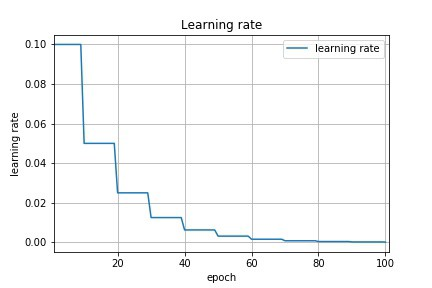

In [ ]:
def step_decay(epoch):
   d = 0.5
   k = 10.0

   ########
   lrate = 
   ########

   return lrate

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath='runs/step_based_decay',
                                      filename='{epoch}-{val_acc:.3f}',
                                      monitor='val_acc', mode='max', save_top_k=1)

model = LightningCIFARClassifierSchedule(step_decay)
trainer = pl.Trainer(gpus=1,
                     precision=16,
                     callbacks=[checkpoint_callback],
                     max_epochs=MAX_EPOCHS)
trainer.fit(model, data_module)

model_test = LightningCIFARClassifierSchedule.load_from_checkpoint(checkpoint_callback.best_model_path)
test_accuracy = trainer.test(model_test, data_module)[0]['test_acc']
print('Test accuracy: ', round(test_accuracy, 3))

### Exponential decay

$lr = lr_0 * e^{−k*{epoch}}$, $lr_0$ - начальный темп,
$k$ - гиперпараметр,
${epoch}$ - число итераций с начала обучения

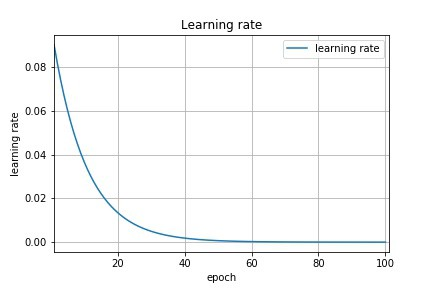

In [ ]:
def exp_decay(epoch):
   k = 0.1

   ########
   lrate = 
   ########

   return lrate

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath='runs/exp_based_decay',
                                      filename='{epoch}-{val_acc:.3f}',
                                      monitor='val_acc', mode='max', save_top_k=1)

model = LightningCIFARClassifierSchedule(exp_decay)
trainer = pl.Trainer(gpus=1,
                     precision=16,
                     callbacks=[checkpoint_callback],
                     max_epochs=MAX_EPOCHS)
trainer.fit(model, data_module)

model_test = LightningCIFARClassifierSchedule.load_from_checkpoint(checkpoint_callback.best_model_path)
test_accuracy = trainer.test(model_test, data_module)[0]['test_acc']
print('Test accuracy: ', round(test_accuracy, 3))

### Warmup
Если ваш датасет достаточно разнообразен, при обучении может возникнуть эффект раннего переобучения. Если перемешанные данные содержат специфический кластер похожих примеров, в начале обучения веса модели могут чрезмерно подстроиться под такие примеры, от чего страдает весь процесс обучения.

Warm-up позволяет снизить влияние такого эффекта на начальных этапах. Пусть темп обучения равен p, и на warm-up отводится n итераций. Тогда в начале обучения темп растет линейно, начиная с $1*p/n$ на первой итерации и, прибавляя по $1*p/n$, постепенно доходит до p. 

Период warm-up как правило длится одну эпоху. В идеале нужно увеличивать продолжительность warm-up в случае специфичности отдельных кластеров данных и можно уменьшать, если данные достаточно гомогенны


In [ ]:
%%capture
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

In [ ]:
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

In [ ]:
class LightningCIFARClassifierWarmupCos(LightningCIFARClassifier):

  def __init__(self, lr_rate=BASE_LR, freeze='most'):
    super(LightningCIFARClassifierWarmupCos, self).__init__(lr_rate, freeze)

  def configure_optimizers(self):

    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr_rate)
    
    ########
    lr_scheduler = 
    ########

    return [optimizer], [lr_scheduler]

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath='runs/warmup_cosine',
                                      filename='{epoch}-{val_acc:.3f}',
                                      monitor='val_acc', mode='max', save_top_k=1)

model = LightningCIFARClassifierWarmupCos()
trainer = pl.Trainer(gpus=1,
                     precision=16,
                     callbacks=[checkpoint_callback],
                     max_epochs=MAX_EPOCHS)
trainer.fit(model, data_module)

model_test = LightningCIFARClassifierWarmupCos.load_from_checkpoint(checkpoint_callback.best_model_path)
test_accuracy = trainer.test(model_test, data_module)[0]['test_acc']
print('Test accuracy: ', round(test_accuracy, 3))

## Аугментации

Расширим обучающую выборку путем аугментаций - случайных изменений обучающих примеров с сохранением их доменных свойств. Используем библиотеку albumentations 

[Документация к albumentations](https://albumentations.ai/docs/)


In [ ]:
train_transform = A.Compose(
    [
        ########
     
        ########
     
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ]
)

data_module_augmented = CIFARDataModule(train_transform=train_transform)

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath='runs/aug',
                                      filename='{epoch}-{val_acc:.3f}',
                                      monitor='val_acc', mode='max', save_top_k=1)

model = LightningCIFARClassifier()
trainer = pl.Trainer(gpus=1,
                     precision=16,
                     callbacks=[checkpoint_callback],
                     max_epochs=MAX_EPOCHS)
trainer.fit(model, data_module_augmented)

model_test = LightningCIFARClassifier.load_from_checkpoint(checkpoint_callback.best_model_path)
test_accuracy = trainer.test(model_test, data_module_augmented)[0]['test_acc']
print('Test accuracy: ', round(test_accuracy, 3))

Попробуем использовать более сложную аугментацию - MixUp - взвешенное усреднение двух изображений с соответствующим изменением one-hot таргета.
[(подробнее)](https://arxiv.org/abs/1710.09412)
Брать пары изображений можно внутри одного батча

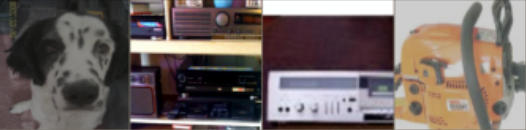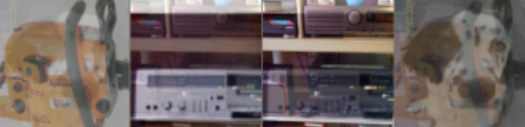

In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):

    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ########
    mixed_x = 
    y_a, y_b = 
    ########

    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):

    ########
    loss = 
    ########

    return loss

In [ ]:
class LightningCIFARClassifierMixUp(LightningCIFARClassifier):

  def __init__(self, lr_rate=BASE_LR, freeze='most'):
    super(LightningCIFARClassifierMixUp, self).__init__(lr_rate, freeze)
    
  
  def training_step(self, train_batch, batch_idx):
      x, y = train_batch

      inputs, targets_a, targets_b, lam = mixup_data(x, y, 1.0, True)
      inputs, targets_a, targets_b = map(Variable, (inputs,
                                                      targets_a, targets_b))

      logits = self.forward(x)
      loss = mixup_criterion(self.cross_entropy_loss, logits, targets_a, targets_b, lam)

      logs = {'train_loss': loss}

      acc = torch.sum(logits.argmax(dim=1) == y) / y.shape[0]
      self.log('train_acc', acc, on_step=True, prog_bar=True)
      self.log('train_loss', loss, on_step=True, prog_bar=True)

      return {'loss': loss, 'log': logs}

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath='runs/mixup',
                                      filename='{epoch}-{val_acc:.3f}',
                                      monitor='val_acc', mode='max', save_top_k=1)

model = LightningCIFARClassifierMixUp()
trainer = pl.Trainer(gpus=1,
                     precision=16,
                     callbacks=[checkpoint_callback],
                     max_epochs=MAX_EPOCHS)
trainer.fit(model, data_module)

model_test = LightningCIFARClassifierMixUp.load_from_checkpoint(checkpoint_callback.best_model_path)
test_accuracy = trainer.test(model_test, data_module)[0]['test_acc']
print('Test accuracy: ', round(test_accuracy, 3))

Похожие способы аугментаций:
* [CutMix](https://arxiv.org/abs/1905.04899)
* [FMix](https://arxiv.org/abs/2002.12047)

## Label smoothing

Модель машинного обучения называется "откалиброванной" (calibrated), если выдаваемая ею вероятность отражает ее качество. Пусть у нас есть 100 примеров, на каждый модель выдает вероятность 0.9. Тогда, если модель "откалибрована", то ровно 90 примеров должны быть классифицированы корректно.

Предсказания "откалиброванной" модели легче интерпретируются, к такой модели проще подбирать пороги и легче добавлять ее в ансамбль.

Чересчур "уверенная" модель (overconfident) склонна выдавать очень высокие скоры. Побороть этот эффект помогает label smoothing. Он может быть использован в связке с softmax+cross-enropy loss. Метод заключается в том, чтобы преобразовать таргет по следующей формуле:

$y_{ls} = (1 - α) * y_{hot} + α / K$, $y_{hot}$ - one-hot представление таргета, $K$ - число классов, $α$ - гиперпараметр, задающий силу сглаживания (обычному представлению таргета соответствует $α$ = 0)

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1, weight = None):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.weight = weight
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        assert 0 <= self.smoothing < 1

        if self.weight is not None:
            pred = pred * self.weight.unsqueeze(0)   

        with torch.no_grad():
            
            #######
            true_dist = 
            #######

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
class LightningCIFARClassifierSmooth(LightningCIFARClassifier):

  def __init__(self, lr_rate=BASE_LR, freeze='most'):
    super(LightningCIFARClassifierSmooth, self).__init__(lr_rate, freeze)

    self.crit = LabelSmoothingLoss(classes=10, smoothing=0.5)

  def training_step(self, train_batch, batch_idx):
      x, y = train_batch
      logits = self.forward(x)

      loss = self.crit(logits, y)

      logs = {'train_loss': loss}

      acc = torch.sum(logits.argmax(dim=1) == y) / y.shape[0]

      self.log('train_acc', acc, on_step=True, prog_bar=True)

      return {'loss': loss, 'log': logs}

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath='runs/smoothing',
                                      filename='{epoch}-{val_acc:.3f}',
                                      monitor='val_acc', mode='max', save_top_k=1)

model = LightningCIFARClassifierSmooth()
trainer = pl.Trainer(gpus=1,
                     precision=16,
                     callbacks=[checkpoint_callback],
                     max_epochs=MAX_EPOCHS)
trainer.fit(model, data_module)

model_test = LightningCIFARClassifierSmooth.load_from_checkpoint(checkpoint_callback.best_model_path)
test_accuracy = trainer.test(model_test, data_module)[0]['test_acc']
print('Test accuracy: ', round(test_accuracy, 3))

Полезные ссылки:
*   [Документация к Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/)
*   [Stanford cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks)

